# WSI - zadanie 4

Artur Kempiński
325168

Użyta technologia:

python==3.11.6

matplotlib==3.8.0

scikit-learn==1.3.2

numpy==1.24.3

pandas==2.0.3

In [239]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import warnings

In [240]:
warnings.filterwarnings('ignore')

# Implementacja

In [241]:
class SVM:
    def __init__(self, kernel='rbf', C=0.8, gamma=0.7):
        if kernel == 'rbf':
            self.kernel = self._linear_kernel
        else:
            self.kernel = self._rbf_kernel
        
        self.C = C
        self.gamma = gamma
        self.X = None
        self.y = None
        self.alphas = None
        self.b = 0

    def _rbf_kernel(self, X1, X2):
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _linear_kernel(self, X1, X2):
        return X1.dot(X2.T)

    def fit(self, X, y, learn_rate=1e-3, epochs=500):

        self.X = X
        self.y = y
        
        amout_of_samples = X.shape[0]

        ones = np.ones(amout_of_samples)

        self.alphas = np.zeros(amout_of_samples)
        self.b = 0

        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)  # (1)

        for _ in range(epochs):
            gradient = ones - y_iy_jk_ij.dot(self.alphas)  # (2)

            self.alphas = self.alphas + learn_rate * gradient

            self.alphas[self.alphas > self.C] = self.C
            self.alphas[self.alphas < 0] = 0

        index = np.where((self.alphas) > 0 & (self.alphas < self.C))[0]

        b_i = y[index] - (self.alphas * y).dot(self.kernel(X, X[index]))  # (3)
        self.b = np.mean(b_i)  # (4)

    def _decision_function(self, X):
        return (self.alphas * self.y).dot(self.kernel(self.X, X)) + self.b  # (5)

    def predict(self, X):
        return np.sign(self._decision_function(X))
    
    def get_condition(self):
        return self.alphas.T.dot(self.y)

(1)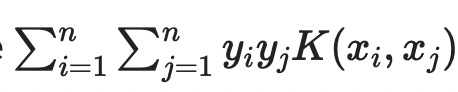

(2)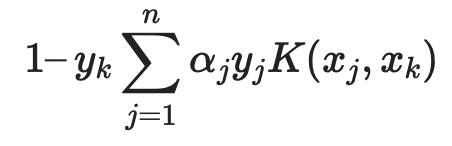

(3)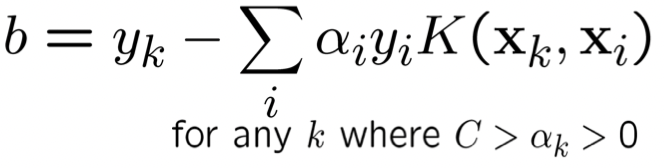

(4)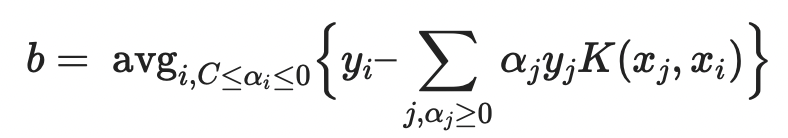

(5)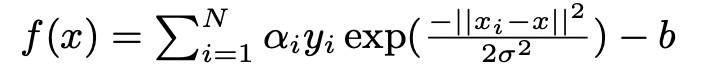

# Funkcje pomocnicze

In [242]:
def initialize_dataset(input_file, random_state):

    dataframe = pd.read_csv(input_file)
    cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
    pre = ['gender', 'group', 'parent_ed', 'lunch', 'prep_course']
    dataframe  = pd.get_dummies(dataframe , columns=cols, prefix=pre, dtype=int)

    dataframe[['math score', 'reading score', 'writing score']] = dataframe[['math score', 'reading score', 'writing score']].astype(int)

    dataframe['passed'] = dataframe.apply(lambda row: 1 if (row['math score'] > 60) & (row['reading score'] > 60) & (row['writing score'] > 60) else -1, axis=1)
    dataframe.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(['passed'], axis=1), dataframe['passed'], test_size=0.2, random_state=random_state)

    return (x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy())

In [243]:
def draw_plot_c(c_test_values, my_metric_avg, sklearn_metric_avg, metric_name, title):
    plt.figure(figsize=(10, 5))
    plt.plot(c_test_values, my_metric_avg, label='My SVM')
    plt.plot(c_test_values, sklearn_metric_avg, label='Sklearn SVM')
    plt.xlabel('C')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(title)
    plt.show()

# Przykładowe macierze pomyłek

In [244]:
x_train, y_train, x_test, y_test = initialize_dataset('exams.csv', 42)
svm_rbf = SVM(kernel='rbf')
svm_rbf.fit(x_train, y_train)
y_pred_rbf = svm_rbf.predict(x_test)

svm_linear = SVM(kernel='linear')
svm_linear.fit(x_train, y_train)
y_pred_linear = svm_linear.predict(x_test)

print('How to read the confusion matrix:')
print('[[TP FP]')
print(' [FN TN]]')

print('My SVM - RBF kernel')
print(confusion_matrix(y_test, y_pred_rbf))

print('My SVM - Linear kernel')
print(confusion_matrix(y_test, y_pred_linear))


How to read the confusion matrix:
[[TP FP]
 [FN TN]]
My SVM - RBF kernel
[[46 38]
 [26 90]]
My SVM - Linear kernel
[[44 40]
 [33 83]]


# Analiza wpływu parametru C na średnie wartości metryk dla różnych zbiorów danych uczących

In [245]:
c_test_values = np.linspace(0.1, 1.2, 30)

my_rbf_accuracies_avg = []
my_rbf_precisions_avg = []
my_rbf_recalls_avg = []

my_linear_accuracies_avg = []
my_linear_precisions_avg = []
my_linear_recalls_avg = []

sklearn_rbf_accuracies_avg = []
sklearn_rbf_precisions_avg = []
sklearn_rbf_recalls_avg = []

sklearn_linear_accuracies_avg = []
sklearn_linear_precisions_avg = []
sklearn_linear_recalls_avg = []

for c in c_test_values:
    my_rbf_accuracies = []
    my_rbf_precisions = []
    my_rbf_recalls = []
    
    my_linear_accuracies = []
    my_linear_precisions = []
    my_linear_recalls = []
    
    sklearn_rbf_accuracies = []
    sklearn_rbf_precisions = []
    sklearn_rbf_recalls = []
    
    sklearn_linear_accuracies = []
    sklearn_linear_precisions = []
    sklearn_linear_recalls = []
    
    for _ in range(10):
        x_train, y_train, x_test, y_test = initialize_dataset('exams.csv', np.random.randint(0, 100))
        
        my_svm_rbf = SVM(kernel='rbf', C=c, gamma=0.7)
        my_svm_rbf.fit(x_train, y_train)
        y_pred = my_svm_rbf.predict(x_test)
        my_rbf_accuracies.append(accuracy_score(y_test, y_pred))
        my_rbf_precisions.append(precision_score(y_test, y_pred))
        my_rbf_recalls.append(recall_score(y_test, y_pred))
        
        sk_svm_rbf = SVC(kernel='rbf', C=c, gamma=0.7)
        sk_svm_rbf.fit(x_train, y_train)
        y_pred = sk_svm_rbf.predict(x_test)
        sklearn_rbf_accuracies.append(accuracy_score(y_test, y_pred))
        sklearn_rbf_precisions.append(precision_score(y_test, y_pred))
        sklearn_rbf_recalls.append(recall_score(y_test, y_pred))
        
        my_svm_linear = SVM(kernel='linear', C=c, gamma=0.7)
        my_svm_linear.fit(x_train, y_train)
        y_pred = my_svm_linear.predict(x_test)
        my_linear_accuracies.append(accuracy_score(y_test, y_pred))
        my_linear_precisions.append(precision_score(y_test, y_pred))
        my_linear_recalls.append(recall_score(y_test, y_pred))
        
        sk_svm_linear = SVC(kernel='linear', C=c, gamma=0.7)
        sk_svm_linear.fit(x_train, y_train)
        y_pred = sk_svm_linear.predict(x_test)
        sklearn_linear_accuracies.append(accuracy_score(y_test, y_pred))
        sklearn_linear_precisions.append(precision_score(y_test, y_pred))
        sklearn_linear_recalls.append(recall_score(y_test, y_pred))
    
    my_rbf_accuracies_avg.append(np.mean(my_rbf_accuracies))
    my_rbf_precisions_avg.append(np.mean(my_rbf_precisions))
    my_rbf_recalls_avg.append(np.mean(my_rbf_recalls))
    
    sklearn_rbf_accuracies_avg.append(np.mean(sklearn_rbf_accuracies))
    sklearn_rbf_precisions_avg.append(np.mean(sklearn_rbf_precisions))
    sklearn_rbf_recalls_avg.append(np.mean(sklearn_rbf_recalls))
    
    my_linear_accuracies_avg.append(np.mean(my_linear_accuracies))
    my_linear_precisions_avg.append(np.mean(my_linear_precisions))
    my_linear_recalls_avg.append(np.mean(my_linear_recalls))
    
    sklearn_linear_accuracies_avg.append(np.mean(sklearn_linear_accuracies))
    sklearn_linear_precisions_avg.append(np.mean(sklearn_linear_precisions))
    sklearn_linear_recalls_avg.append(np.mean(sklearn_linear_recalls))

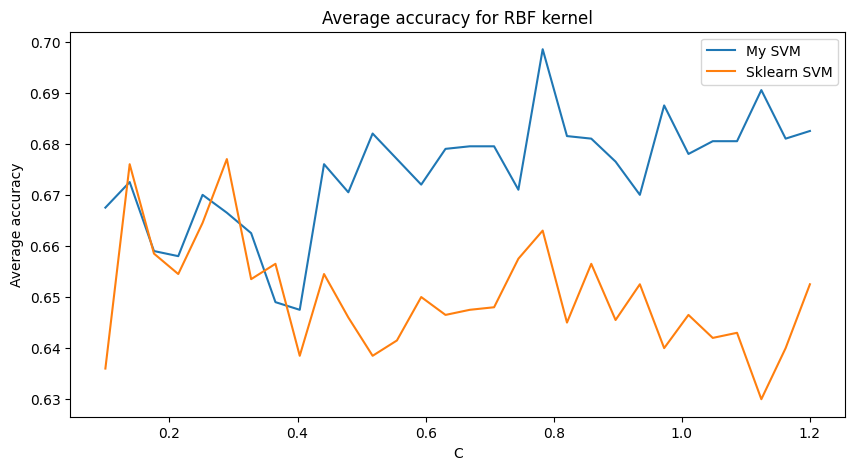

In [246]:
draw_plot_c(c_test_values, my_rbf_accuracies_avg, sklearn_rbf_accuracies_avg, 'Average accuracy', 'Average accuracy for RBF kernel')

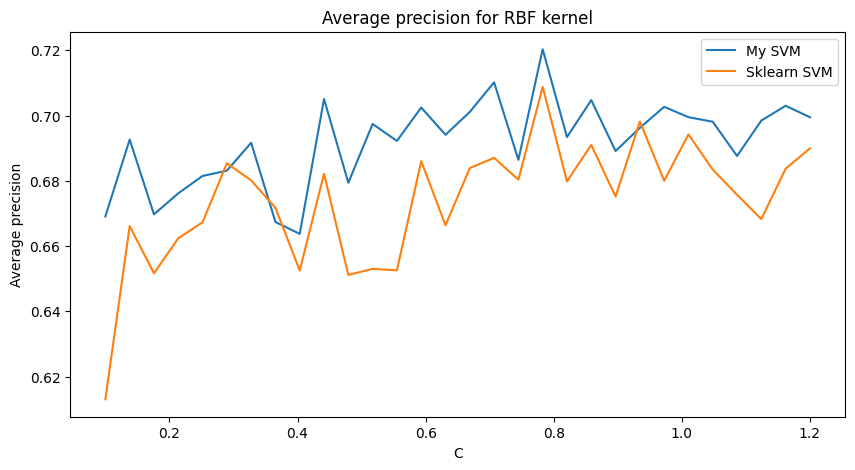

In [247]:
draw_plot_c(c_test_values, my_rbf_precisions_avg, sklearn_rbf_precisions_avg, 'Average precision', 'Average precision for RBF kernel')

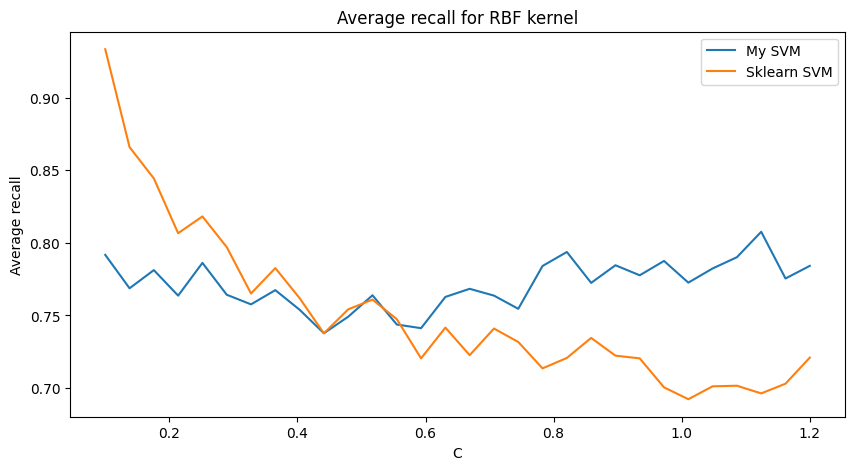

In [248]:
draw_plot_c(c_test_values, my_rbf_recalls_avg, sklearn_rbf_recalls_avg, 'Average recall', 'Average recall for RBF kernel')

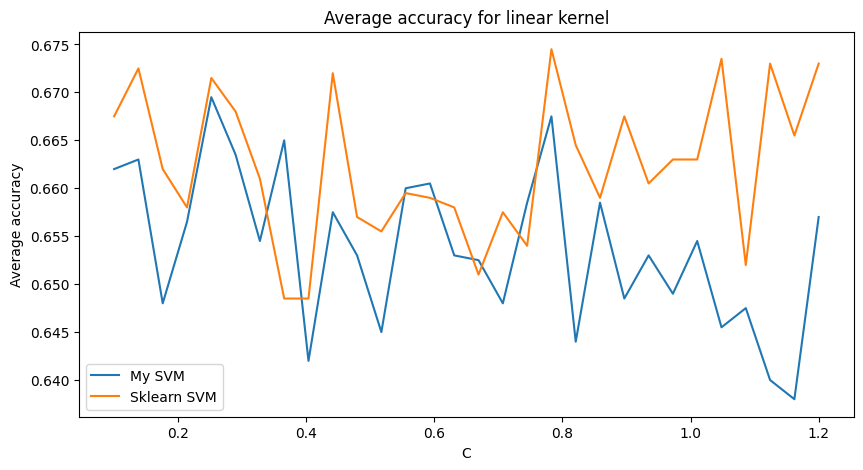

In [249]:
draw_plot_c(c_test_values, my_linear_accuracies_avg, sklearn_linear_accuracies_avg, 'Average accuracy', 'Average accuracy for linear kernel')

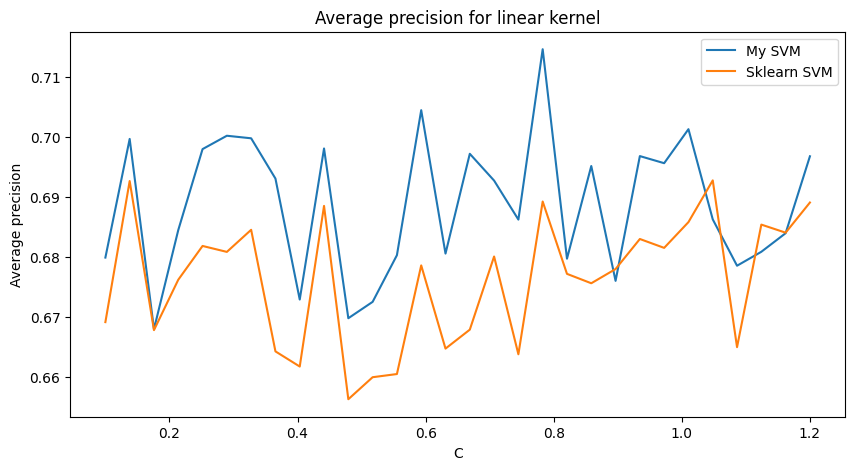

In [250]:
draw_plot_c(c_test_values, my_linear_precisions_avg, sklearn_linear_precisions_avg, 'Average precision', 'Average precision for linear kernel')

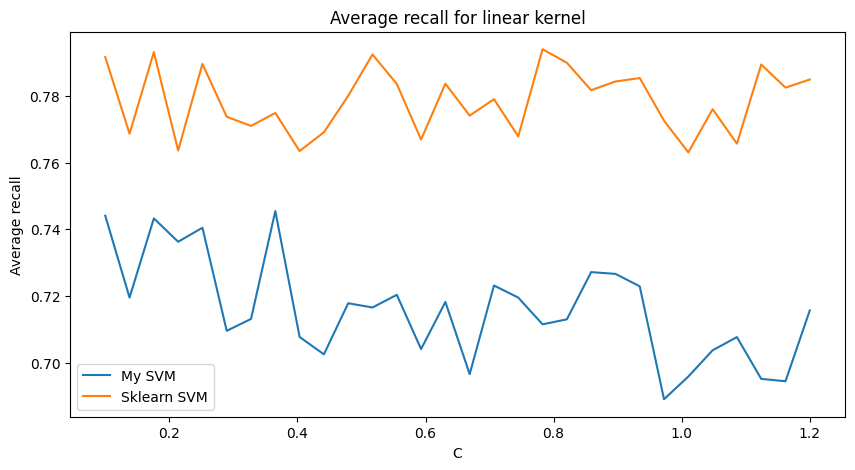

In [251]:
draw_plot_c(c_test_values, my_linear_recalls_avg, sklearn_linear_recalls_avg, 'Average recall', 'Average recall for linear kernel')

Po analizie wykresów ze średnich metryk dochodze do wniosków:

* o dziwo zaimplementowany przeze mnie SVM osiąga dla większości C lepsze wyniki metryk, szczególnie dla jądra RBF
* wydaje mi się, że wpływ wartości parametru C na metryki jest zależny od doboru danych uczących oraz testujących (to samo C dla jednego zbioru uczacego może być najlepsze, a dla innego niekoniecznie)

# Analiza wpływu parametru C na metryki dla pojedynczego zbioru uczącego

In [252]:
x_train, y_train, x_test, y_test = initialize_dataset('exams.csv', 42)
c_test_values = np.linspace(0.1, 1.2, 30)

my_rbf_accuracies = []
my_rbf_precisions = []
my_rbf_recalls = []

sklearn_rbf_accuracies = []
sklearn_rbf_precisions = []
sklearn_rbf_recalls = []

my_linear_accuracies = []
my_linear_precisions = []
my_linear_recalls = []

sklearn_linear_accuracies = []
sklearn_linear_precisions = []
sklearn_linear_recalls = []

for c in c_test_values:
    my_svm_rbf = SVM(kernel='rbf', C=c, gamma=0.7)
    my_svm_rbf.fit(x_train, y_train)
    y_pred = my_svm_rbf.predict(x_test)
    my_rbf_accuracies.append(accuracy_score(y_test, y_pred))
    my_rbf_precisions.append(precision_score(y_test, y_pred))
    my_rbf_recalls.append(recall_score(y_test, y_pred))

    sk_svm_rbf = SVC(kernel='rbf', C=c, gamma=0.7)
    sk_svm_rbf.fit(x_train, y_train)
    y_pred = sk_svm_rbf.predict(x_test)
    sklearn_rbf_accuracies.append(accuracy_score(y_test, y_pred))
    sklearn_rbf_precisions.append(precision_score(y_test, y_pred))
    sklearn_rbf_recalls.append(recall_score(y_test, y_pred))
    
    my_svm_linear = SVM(kernel='linear', C=c, gamma=0.7)
    my_svm_linear.fit(x_train, y_train)
    y_pred = my_svm_linear.predict(x_test)
    my_linear_accuracies.append(accuracy_score(y_test, y_pred))
    my_linear_precisions.append(precision_score(y_test, y_pred))
    my_linear_recalls.append(recall_score(y_test, y_pred))
    
    sk_svm_linear = SVC(kernel='linear', C=c, gamma=0.7)
    sk_svm_linear.fit(x_train, y_train)
    y_pred = sk_svm_linear.predict(x_test)
    sklearn_linear_accuracies.append(accuracy_score(y_test, y_pred))
    sklearn_linear_precisions.append(precision_score(y_test, y_pred))
    sklearn_linear_recalls.append(recall_score(y_test, y_pred))

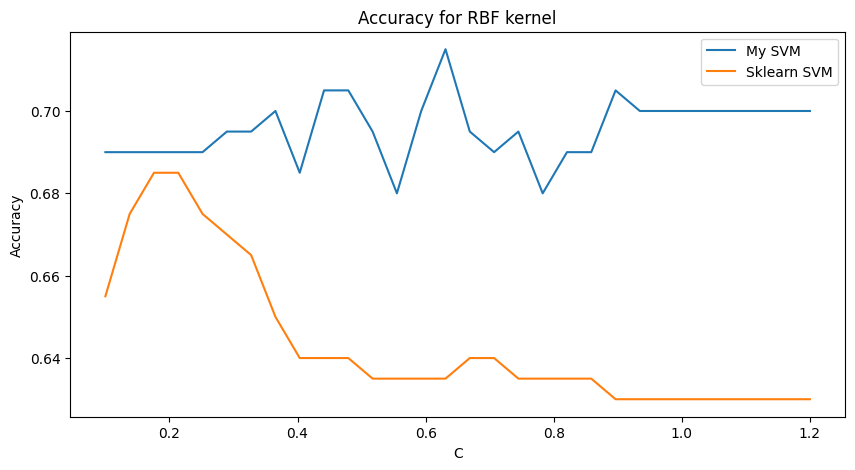

In [253]:
draw_plot_c(c_test_values, my_rbf_accuracies, sklearn_rbf_accuracies, 'Accuracy', 'Accuracy for RBF kernel')

Dla tego konkretnego podziału danych na zbiór uczący oraz testowy, w kontekście dokładności mój SVM radzi sobie najlepiej dla C z z zakresu ~(0.4, 0.7)

SVM ze sklearn za to osiąga najlepsze wyniki dla zakresu ~(0.1, 0.3)

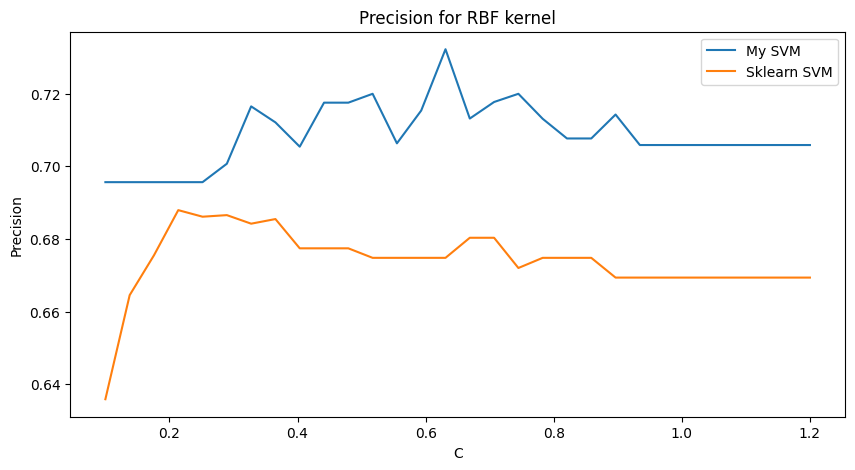

In [254]:
draw_plot_c(c_test_values, my_rbf_precisions, sklearn_rbf_precisions, 'Precision', 'Precision for RBF kernel')

Tutaj wyniki zdają się pokrywać z wynikami dotyczącymi dokładności

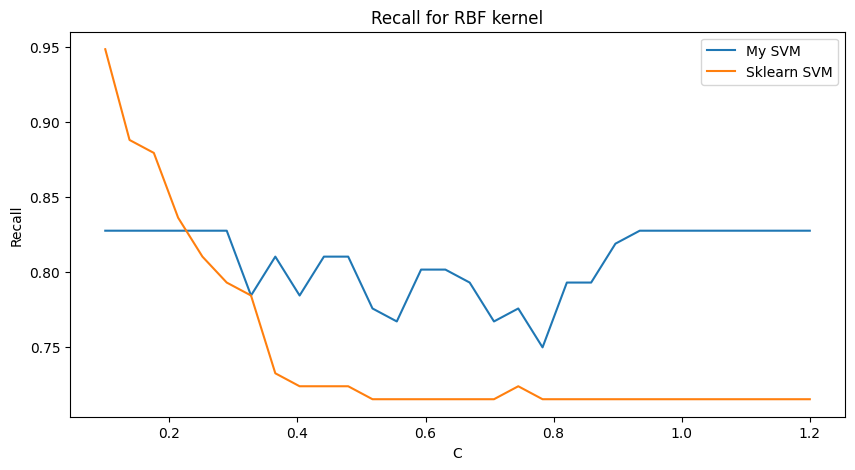

In [255]:
draw_plot_c(c_test_values, my_rbf_recalls, sklearn_rbf_recalls, 'Recall', 'Recall for RBF kernel')

Mój SVM w kontekście czułości radzi sobie bardzo podobnie na całym zakresie C, z lekko niższym wynikiem dla C ~(0.4, 0.9)

SVM ze sklearn zbliża się czułością do 1.0 dla bardzo niskiego C, jednak wskaźnik gwałtownie spada wraz ze wzrostem C i zdaje się osiągać minimum w okolicach C=0.4

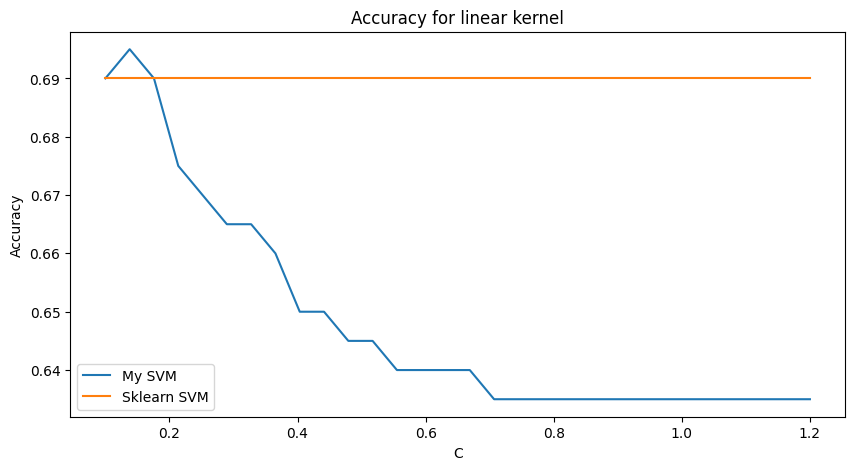

In [256]:
draw_plot_c(c_test_values, my_linear_accuracies, sklearn_linear_accuracies, 'Accuracy', 'Accuracy for linear kernel')

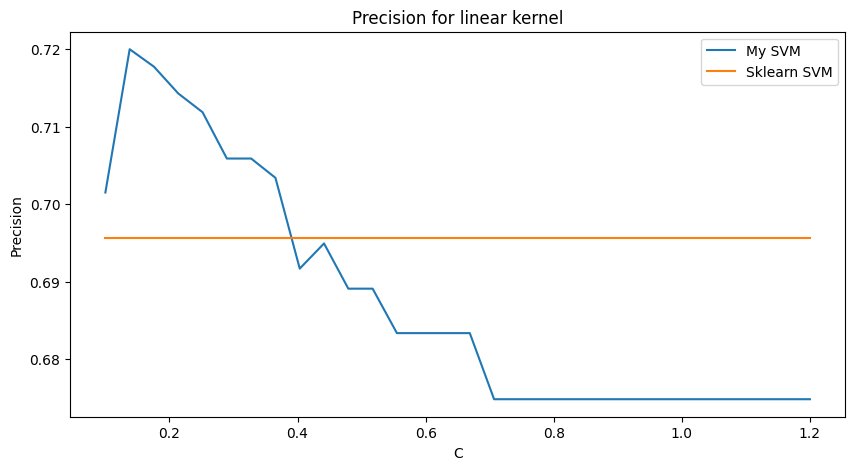

In [257]:
draw_plot_c(c_test_values, my_linear_precisions, sklearn_linear_precisions, 'Precision', 'Precision for linear kernel')

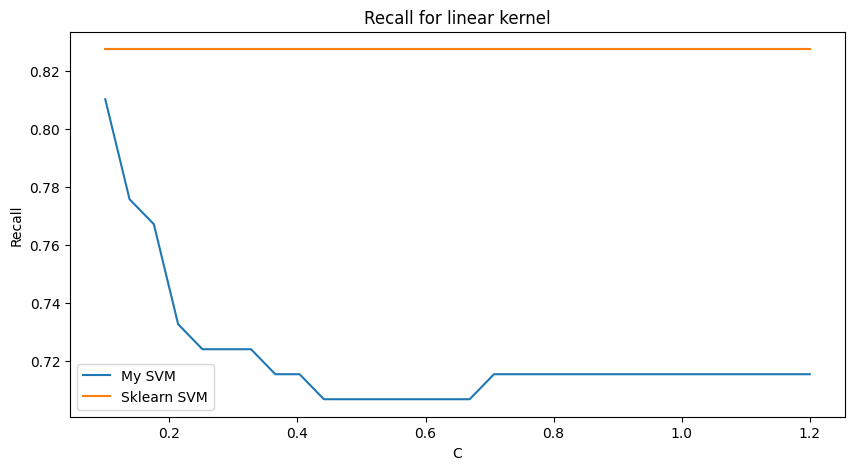

In [258]:
draw_plot_c(c_test_values, my_linear_recalls, sklearn_linear_recalls, 'Recall', 'Recall for linear kernel')

Dla jądra liniowego mój SVM osiąga najlepsze wyniki dla każdej metryki dla C~0.15

Parametr C nie ma żadnego wpływu na wyniki działania SVM z sklearn dla jądra liniowego

# Warunek alfaT * y = 0

In [259]:
x_train, y_train, x_test, y_test = initialize_dataset('exams.csv', 42)
svm_rbf = SVM(kernel='rbf', C=0.8, gamma=0.7)
svm_lin = SVM(kernel='linear', C=0.8, gamma=0.7)

svm_rbf.fit(x_train, y_train)
svm_lin.fit(x_train, y_train)

print('RBF: alfaT * y = ', svm_rbf.get_condition())
print('Linear: alfaT * y = ', svm_lin.get_condition())

RBF: alfaT * y =  0.09316228033385521
Linear: alfaT * y =  3.624455045683402


Dla obu przypadków warunek nie zachodzi. Nie wiem co powinienem zrobić, aby zachodził. Co ciekawe, mimo to implementacja działa. Powód wykracza poza moje zrozumienie tematu.

# Materiały pomocnicze

Materiały z których korzystałem podczas implementacji:
* wykład
* https://www.cs.cmu.edu/~aarti/Class/10315_Fall20/lecs/svm_dual_kernel.pdf
* https://www.cs.princeton.edu/courses/archive/spring16/cos495/slides/AndrewNg_SVM_note.pdf
* https://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-training-algorithms/